## Download del dataset dalla libreria medmnist

In [1]:
!pip install medmnist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier


from medmnist.dataset import ChestMNIST
Dataset = ChestMNIST
dataset = Dataset(split='val', download=True)
label_map = dataset.info['label']

Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz


# Informazioni su ChestMNIST
Il ChestMNIST si basa sul set di dati NIH-ChestXray14,  
un set di dati che comprende __112.120 immagini__ radiografiche con vista frontale di 30.805 pazienti unici con __14 etichette__ di malattia estratte dal testo, che potrebbero essere formulate come un compito di classificazione binario multi-label.  
Utilizziamo la suddivisione dei dati ufficiali e ridimensioniamo le immagini di partenza di 1×1024×1024 in __1×28×28__.  
  
Le etichette sono:
- 0: **atelectasis** (atelettasia): collasso del tessuto polmonare con perdita di volume
- 1: **cardiomegaly** (cardiomegalia): aumento del volume o della massa del cuore dovuto ad aumento dello spessore delle sue pareti o a dilatazione abnorme delle sue cavità
- 2: **effusion** (versamento): accumulo anormale di liquido o pus all'interno della cavità pleurica
- 3: **infiltration** (infiltrazione): accumulo di cellule infiammatorie o di altre sostanze all'interno dei tessuti polmonari
- 4: **mass** (massa): formazione anomala di tessuto all'interno dei polmoni
- 5: **nodule** (nodulo): piccola massa o grumo di tessuto all'interno dei polmoni
- 6: **pneumonia** (polmonite): infiammazione dei polmoni causata da un'infezione batterica, virale o fungina
- 7: **pneumothorax** (pneumotorace): presenza di aria nella cavità pleurica che separa i polmoni dalla parete toracica
- 8: **consolidation** (consolidamento): sostituzione dell'aria nei polmoni con liquido o tessuto solido
- 9: **edema** (edema): accumulo di liquido nei tessuti polmonari
- 10: **emphysema** (enfisema): danneggiamento dei piccoli sacchi d'aria (alveoli) nei polmoni
- 11: **fibrosis** (fibrosi): formazione di tessuto cicatriziale fibroso nei polmoni
- 12: **pleural** (pleurite): infiammazione della membrana che riveste i polmoni e la cavità toracica
- 13: **hernia** (ernia): sporgenza di un organo attraverso una debolezza o un difetto nella parete muscolare o nel tessuto che lo contiene

Divisione del dataset:
{'train': 78468, 'val': 11219, 'test': 22433}


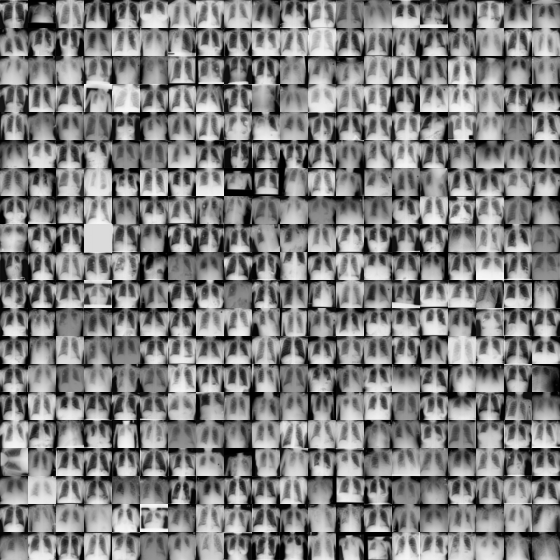

In [3]:
print("Divisione del dataset:")
print(dataset.info['n_samples'])
dataset.montage(20)

# Estrazione del train set e del test set

In [4]:
X_train, Y_train = Dataset(split='train',download=True).imgs, Dataset(split='train',download=True).labels
X_test, Y_test = Dataset(split='test',download=True).imgs, Dataset(split='test',download=True).labels

Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/chestmnist.npz


In [5]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [6]:
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [7]:
Y_train = np.argmax(Y_train, axis=1)
Y_test = np.argmax(Y_test, axis=1)

In [8]:
# Distribuzione delle classi nel train set
print(pd.Series(Y_train).value_counts())

0     50401
3      9483
2      6445
4      2313
5      2292
7      1935
1      1686
8      1060
12      761
10      676
11      535
9       503
6       307
13       71
Name: count, dtype: int64


In [9]:
# Distribuzione delle classi nel test set
print(pd.Series(Y_test).value_counts())

0     14348
3      2700
2      1832
5       731
4       657
7       539
1       502
8       274
12      247
10      206
11      174
9       116
6        86
13       21
Name: count, dtype: int64


### Prepariamo il dataset per la classificazione binaria

In [10]:
Y_train_binary = np.where(Y_train == 0, 0, 1)
Y_test_binary = np.where(Y_test == 0, 0, 1)

X_train_no_class_0 = X_train[Y_train != 0]
Y_train_no_class_0 = Y_train[Y_train != 0]
X_test_no_class_0 = X_test[Y_test != 0]
Y_test_no_class_0 = Y_test[Y_test != 0]

In [11]:
print(pd.Series(Y_train_binary).value_counts())

0    50401
1    28067
Name: count, dtype: int64


In [12]:
under_sampler = RandomUnderSampler(random_state=0,)
X_train_binary_balanced, Y_train_binary_balanced = under_sampler.fit_resample(X_train, Y_train_binary )
X_test_binary_balanced, Y_test_binary_balanced = under_sampler.fit_resample(X_test, Y_test_binary )

In [13]:
print(pd.Series(Y_train_binary_balanced).value_counts())

0    28067
1    28067
Name: count, dtype: int64


In [14]:
print(pd.Series(Y_train_no_class_0 ).value_counts())

3     9483
2     6445
4     2313
5     2292
7     1935
1     1686
8     1060
12     761
10     676
11     535
9      503
6      307
13      71
Name: count, dtype: int64


In [15]:
smote = SMOTE(random_state=0)
X_train_no_class_0_balanced, Y_train_no_class_0_balanced = smote.fit_resample(X_train_no_class_0, Y_train_no_class_0)
X_test_no_class_0_balanced, Y_test_no_class_0_balanced = smote.fit_resample(X_test_no_class_0, Y_test_no_class_0)

In [16]:
print(pd.Series(Y_train_no_class_0_balanced).value_counts())

3     9483
7     9483
2     9483
5     9483
1     9483
8     9483
10    9483
4     9483
12    9483
6     9483
11    9483
9     9483
13    9483
Name: count, dtype: int64


In [64]:
X_test_balanced, Y_test_balanced = smote.fit_resample(X_test, Y_test)

# Classificazione Binaria

## Minimi vicini

In [ ]:
grid = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_binary_balanced, Y_train_binary_balanced)
search_params.best_params_

In [33]:
grid.score(X_test_binary_balanced, Y_test_binary_balanced)

0.5904761904761905

In [34]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_TEST_SCORE,MEAN_SCORE_TIME
9,1,95,"0,60701164","26,23104181"
1,2,87,"0,60669098","38,73189778"
5,3,93,"0,60669098","37,75765915"
3,4,56,"0,60651289","38,37051721"
8,5,55,"0,60645944","36,36160235"
7,6,74,"0,60628128","38,21914649"
4,7,76,"0,60615654","37,34054151"
0,8,27,"0,60207706","39,04533315"
6,9,17,"0,59903080","37,35616121"
2,10,3,"0,57177465","37,67117977"


(0.0, 100.0)

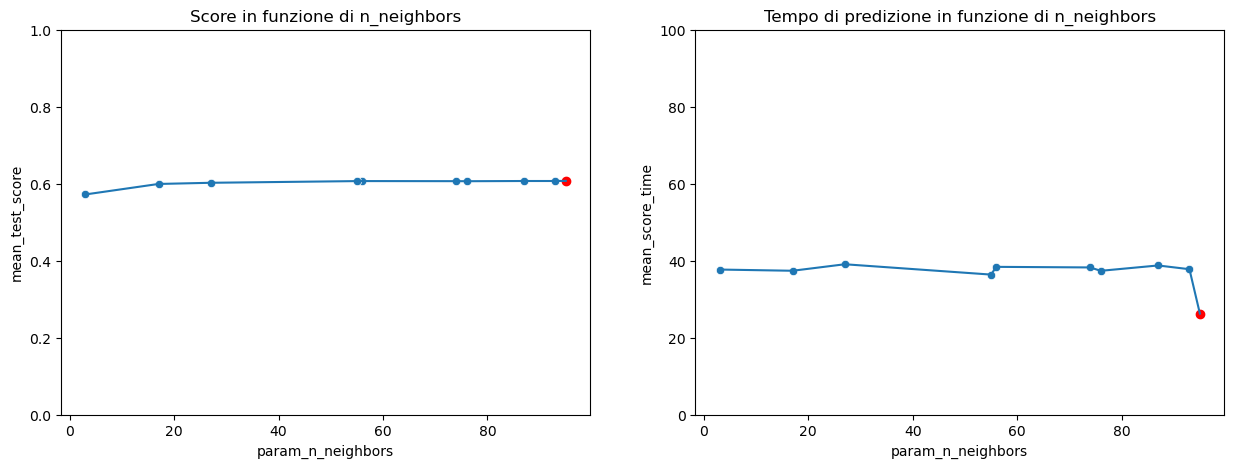

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_neighbors = best.param_n_neighbors
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,100)

In [37]:
cls = KNeighborsClassifier(n_neighbors=best_n_neighbors,n_jobs=-1,random_state=0)
cls.fit(X_train_binary_balanced, Y_train_binary_balanced)

KNeighborsClassifier(n_jobs=-1, n_neighbors=95)

In [38]:
cls.score(X_test_binary_balanced, Y_test_binary_balanced)

0.5904761904761905

In [42]:
y_pred_kn = cls.predict(X_test_binary_balanced)

In [43]:
accuracy_score(Y_test_binary_balanced, y_pred_kn)

0.5904761904761905

In [44]:
print(classification_report(Y_test_binary_balanced, y_pred_kn))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      8085
           1       0.62      0.48      0.54      8085

    accuracy                           0.59     16170
   macro avg       0.60      0.59      0.59     16170
weighted avg       0.60      0.59      0.59     16170



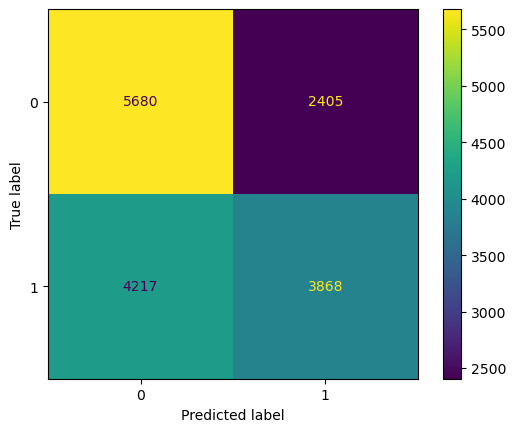

In [45]:
confusion_matrix(Y_test_binary_balanced, y_pred_kn)
ConfusionMatrixDisplay(confusion_matrix(Y_test_binary_balanced, y_pred_kn)).plot()

## Random Forest

In [ ]:
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), {'n_estimators': range(1, 100), 'max_depth': range(1,100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_scaled, Y_train_binary)
search_params.best_params_

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,100)

In [ ]:
cls = RandomForestClassifier(n_estimators= 97, max_depth=59, n_jobs=-1)
cls.fit(X_train_scaled, Y_train_binary)

In [ ]:
cls.score(X_test_scaled, Y_test_binary)

In [ ]:
y_pred_binary = cls.predict(X_test_scaled)

In [ ]:
accuracy_score(Y_test_binary, y_pred_binary)

In [ ]:
print(classification_report(Y_test_binary, y_pred_binary))

In [ ]:
confusion_matrix(Y_test_binary, y_pred_binary)
ConfusionMatrixDisplay(confusion_matrix(Y_test_binary, y_pred_binary)).plot()

# Classificazione multipla

## Minimi vicini

In [46]:
grid = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_no_class_0_balanced, Y_train_no_class_0_balanced)
search_params.best_params_

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,100)

In [48]:
cls = KNeighborsClassifier(n_jobs=-1)
cls.fit(X_train_no_class_0_balanced, Y_train_no_class_0_balanced)

KNeighborsClassifier(n_jobs=-1)

In [49]:
cls.score(X_test_no_class_0_balanced, Y_test_no_class_0_balanced)

0.13193732193732194

In [50]:
y_pred_multi_kn = cls.predict(X_test_no_class_0_balanced)

In [52]:
accuracy_score(Y_test_no_class_0_balanced ,y_pred_multi_kn)

0.13193732193732194

In [53]:
print(classification_report(Y_test_no_class_0_balanced, y_pred_multi_kn))

              precision    recall  f1-score   support

           1       0.14      0.20      0.16      2700
           2       0.13      0.14      0.14      2700
           3       0.14      0.06      0.08      2700
           4       0.09      0.12      0.10      2700
           5       0.11      0.18      0.14      2700
           6       0.06      0.05      0.05      2700
           7       0.15      0.14      0.14      2700
           8       0.11      0.15      0.13      2700
           9       0.23      0.28      0.25      2700
          10       0.17      0.13      0.15      2700
          11       0.16      0.14      0.15      2700
          12       0.10      0.10      0.10      2700
          13       0.17      0.04      0.06      2700

    accuracy                           0.13     35100
   macro avg       0.13      0.13      0.13     35100
weighted avg       0.13      0.13      0.13     35100



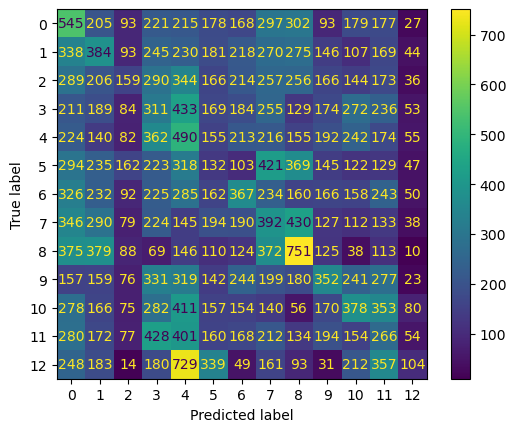

In [54]:
confusion_matrix(Y_test_no_class_0_balanced, y_pred_multi_kn)
ConfusionMatrixDisplay(confusion_matrix(Y_test_no_class_0_balanced, y_pred_multi_kn)).plot()

## Random Forest

In [ ]:
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1), {'n_estimators': range(1, 100), 'max_depth': range(1,100)}, n_iter=10, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train_no_class_0_balanced, Y_train_no_class_0_balanced)
search_params.best_params_

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators e max_depth')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,100)

# Predizione generale

In [55]:
cls_binary = RandomForestClassifier(random_state=0, n_jobs=-1)
cls_multi = RandomForestClassifier(random_state=0, n_jobs=-1)

In [56]:
cls_binary.fit(X_train_binary_balanced, Y_train_binary_balanced)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [57]:
cls_multi.fit(X_train_no_class_0_balanced,Y_train_no_class_0_balanced)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [65]:
y_pred_rf = cls_binary.predict(X_test_balanced)
other_class_indices = np.where(y_pred_rf != 0)[0]
y_pred_rf[other_class_indices] = cls_multi.predict(X_test_balanced.iloc[other_class_indices])

In [66]:
accuracy_score(Y_test_balanced, y_pred_rf)

0.13564857222509857

In [67]:
print(classification_report(Y_test_balanced, y_pred_rf))

              precision    recall  f1-score   support

           0       0.10      0.64      0.17     14348
           1       0.25      0.18      0.21     14348
           2       0.15      0.35      0.21     14348
           3       0.10      0.15      0.12     14348
           4       0.12      0.04      0.06     14348
           5       0.10      0.02      0.04     14348
           6       0.08      0.00      0.01     14348
           7       0.20      0.10      0.13     14348
           8       0.17      0.11      0.13     14348
           9       0.36      0.24      0.29     14348
          10       0.21      0.03      0.06     14348
          11       0.16      0.01      0.02     14348
          12       0.07      0.01      0.01     14348
          13       0.22      0.00      0.00     14348

    accuracy                           0.14    200872
   macro avg       0.16      0.14      0.10    200872
weighted avg       0.16      0.14      0.10    200872



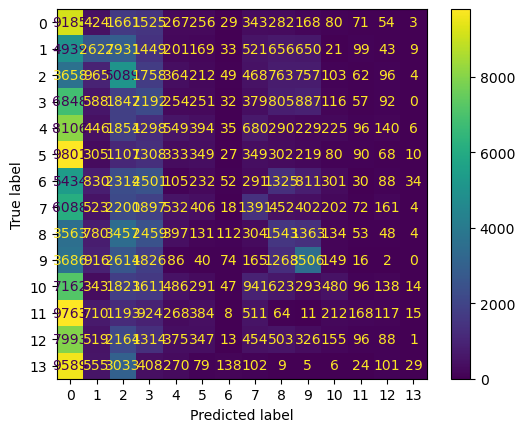

In [68]:
matrix = confusion_matrix(Y_test_balanced, y_pred_rf)
ConfusionMatrixDisplay(matrix).plot()

## Other

In [ ]:
cls = RandomForestClassifier(n_estimators= 97, max_depth= 33,n_jobs=-1)
cls.fit(X_train_no_class_0, Y_train_no_class_0)

In [ ]:
cls.score(X_test_no_class_0, Y_test_no_class_0)

In [ ]:
# prendo gli indici degli esempi classificati come 1
y_test_other_class_indeces = np.where(y_pred_binary_kn != 0)[0]

In [ ]:
y_pred_binary_kn[y_test_other_class_indeces] = cls.predict(X_test_scaled.iloc[y_test_other_class_indeces])

In [ ]:
accuracy_score(Y_test ,y_pred_binary_kn)

In [ ]:
print(classification_report(Y_test, y_pred_binary_kn))

In [ ]:
confusion_matrix(Y_test, y_pred_binary_kn)
ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred_binary_kn)).plot()

# OLD

# Minimi Vicini vs Random Forest

## Minimi vicini


In [ ]:
grid = GridSearchCV(KNeighborsClassifier(weights='uniform',n_jobs=-1), {'n_neighbors':[1,10,100,500,1000]}, cv=2, n_jobs=-1)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[2]
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,20)

## Random Forest Classifier

In [ ]:
grid = GridSearchCV(RandomForestClassifier(random_state=0), {'n_estimators':[1,10,100],'max_depth':[1,10,50,100]}, cv=2)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

## LDA 2D

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_balanced, Y_train_balanced)
X_test_lda = lda.transform(X_test_scaled)

In [ ]:
sns.scatterplot(data=pd.DataFrame(X_train_lda, columns=['lda1','lda2']), x='lda1', y='lda2', hue=Y_train_balanced)

In [ ]:
idx0 = Y_train== 1
idx1 = Y_train== 3

Y_train_filtered = Y_train[idx0 | idx1]
X_train_lda_filtered= X_train_lda[idx0 | idx1]

sns.scatterplot(data=pd.DataFrame(X_train_lda_filtered, columns=['lda1','lda2']), x='lda1', y='lda2', hue=Y_train_filtered).set_title('Classificazione multiclasse')

## LDA 3D

In [ ]:
lda3 = LinearDiscriminantAnalysis(n_components=3)
X_train_lda3 = lda3.fit_transform(X_train_scaled, Y_train)
X_test_lda3 = lda3.transform(X_test_scaled)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_lda3[:,0], X_train_lda3[:,1], X_train_lda3[:,2], c=Y_train)
ax.set_xlabel('lda1')
ax.set_ylabel('lda2')
ax.set_zlabel('lda3')

### LDA 3D con minimi vicini

In [ ]:
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':[1,10,100,500]}, cv=2)
grid.fit(X_train_lda3, Y_train)
grid.score(X_test_lda3, Y_test)
print("Miglior modello: ", grid.best_params_)
print("Miglior score: ", grid.best_score_)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_test_score","mean_score_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di max_depth')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di max_depth')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,5)

### LDA 3D con Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

grid = GridSearchCV(RandomForestClassifier(random_state=0), {'n_estimators':[1],'max_depth':[1,5,10,25,50,75,100]}, cv=2)
grid.fit(X_train_scaled, Y_train)
grid.score(X_test_scaled, Y_test)
print("Miglior modello: ", grid.best_params_)
print("Miglior score: ", grid.best_score_)

In [ ]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_max_depth","mean_test_score","mean_fit_time"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_max_depth', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di max_depth')
sns.scatterplot(data=df, x='param_max_depth', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
ax[0].scatter(best.param_max_depth, best.mean_test_score, color='red')
ax[0].set_ylim(0,1)

sns.lineplot(data=df, x='param_max_depth', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di max_depth')
sns.scatterplot(data=df, x='param_max_depth', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_max_depth, best.mean_fit_time, color='red')
ax[1].set_ylim(0,1)

# Classificazione multipla

## Majority vote rule

In [ ]:
cls = VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=10,n_jobs=-1)),('rf', RandomForestClassifier(n_estimators=1, max_depth=1,random_state=0))], n_jobs=-1)
cls.fit(X_train_scaled, Y_train)

In [ ]:
cls.score(X_test_scaled, Y_test)

In [ ]:
y_pred = cls.predict(X_test_scaled)

In [ ]:
accuracy_score(Y_test, y_pred)

In [ ]:
print(classification_report(Y_test, y_pred))

In [ ]:
matrix = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(matrix).plot()

## Uno contro Tutti

In [ ]:
cls = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)
cls.fit(X_train_scaled, Y_train)

In [ ]:
cls.score(X_test_scaled, Y_test)

In [ ]:
y_pred= cls.predict(X_test_scaled)

In [ ]:
accuracy_score(Y_test, y_pred)

In [ ]:
print(classification_report(Y_test, y_pred))

In [ ]:
matrix = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(matrix).plot()

## Uno contro uno

In [ ]:
cls = OneVsOneClassifier(RandomForestClassifier(n_estimators=1, max_depth=1))
cls.fit(X_train_scaled, Y_train)

In [ ]:
cls.score(X_test_scaled, Y_test)

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='covariance_eigh')
pca.fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

# Conclusioni

In [ ]:
cls = RandomForestClassifier(n_estimators=100, max_depth=10)
cls.fit(X_train_balanced, Y_train_balanced)
cls.score(X_test_balanced, Y_test_balanced)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=0, sampling_strategy={
    0: 3000,
    3: 2000,
    2: 2000,
    4: 1000,
    5: 1000,
    7: 1000,
    1: 1000,
    8: 1000,
    12: 761,
    10: 676,
    11: 535,
    9: 503,
    6: 307,
    13: 71
})
X_train_under, Y_train_under = under_sampler.fit_resample(X_train_scaled, Y_train)

In [ ]:
from imblearn.over_sampling import SMOTE
# Applicare SMOTE per bilanciare il dataset
smote = SMOTE(random_state=0, sampling_strategy='auto')
print(smote.fit(X_train_scaled, Y_train))
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train_under, Y_train_under)

In [ ]:
print(pd.Series(Y_train_balanced).value_counts())

In [ ]:
under_sampler = RandomUnderSampler(random_state=0, sampling_strategy={
    0: 1000,
    3: 800,
    2: 800,
    5: 500,
    4: 500,
    7: 500,
    1: 400,
    8: 274,
    12: 247,
    10: 206,
    11: 174,
    9: 116,
    6: 86,
    13: 21
})
X_test_under, Y_test_under = under_sampler.fit_resample(X_test_scaled, Y_test)

In [ ]:
smote = SMOTE(random_state=0, sampling_strategy='auto')
X_test_balanced, Y_test_balanced = smote.fit_resample(X_test_under, Y_test_under)

In [ ]:
print(pd.Series(Y_test_balanced).value_counts())

# Classificazione binaria

In [ ]:
Y_train_binary = np.where(Y_train == 0, 0, 1)
Y_test_binary = np.where(Y_test == 0, 0, 1)

In [ ]:
print(pd.Series(Y_train_binary).value_counts())

In [ ]:
cls = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
cls.fit(X_train_scaled, Y_train_binary)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
cls = BaggingClassifier(SVC(), n_estimators=10, n_jobs=-1)
cls.fit(X_train_scaled, Y_train_binary)

In [ ]:
cls.score(X_test_scaled, Y_test_binary)

In [ ]:
y_pred = cls.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test_binary, y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test_binary, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(Y_test_binary, y_pred)
ConfusionMatrixDisplay(confusion_matrix).plot()